# Bag of Visual Words

This notebook demonstrates the Bag of Visual Words model for image classification using the CIFAR 10 dataset.

In [4]:
%matplotlib inline

# import kmeans and SIFT from scikit-image and scikit-learn
from skimage.feature import SIFT
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Import CIFAR-10 dataset
from sklearn.datasets import fetch_openml

In [5]:
# Load the CIFAR-10 dataset
cifar = fetch_openml('CIFAR_10_small', version=1)

/home/alex/anaconda3/envs/cse4310/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


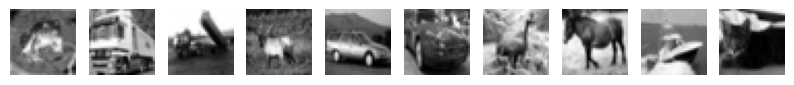

In [6]:
# Convert the input data to a numpy array. It is saved in row-major order where the first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.
cifar_rgb = np.array(cifar.data, dtype='uint8')

# Reshape the data to (num_images, height, width, num_channels)
cifar_rgb = cifar_rgb.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Convert the images to grayscale
cifar_gray = rgb2gray(cifar_rgb)

# Visualize the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(cifar_gray[i], cmap='gray')
    ax.axis('off')
plt.show()

# Extracting Visual Features

In order to build a vocabulary, all visual features must be extracted. Depending on the detector and the image, the number of features can vary. The detector may not be able to detect any features in some images.

In [15]:
from tqdm import tqdm
# Extract SIFT features per class
sift = SIFT()
sift_features = []
y_features = []

for idx in tqdm(range(cifar_gray.shape[0]), desc="Processing images"):
    try:
        sift.detect_and_extract(cifar_gray[idx])
        sift_features.append(sift.descriptors)
        y_features.append(cifar.target[idx]) # Only stores the label if the SIFT features are successfully extracted
    except:
        pass

Processing images: 100%|██████████| 20000/20000 [02:53<00:00, 115.50it/s]


# Building a Vocabulary

The vocabulary itself is built by clustering visual features. The size of the vocabulary is a hyperparameter that can be tuned.

In [8]:
# Convert the list of SIFT features to a numpy array
sift_features_np = np.concatenate(sift_features)

# Create a KMeans model to cluster the SIFT features
vocab_size = 100
kmeans = KMeans(n_clusters=vocab_size, random_state=42)

# Fit the KMeans model to the SIFT features
kmeans.fit(sift_features_np)

/home/alex/anaconda3/envs/cse4310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=50, random_state=42)

# Encoding Images

Each image is encoded by counting the number of visual words that are present in the image. This is done by finding the nearest visual word for each visual feature and incrementing the count of that visual word.

In [10]:
# Build a histogram of the cluster centers for each image using the features already extracted
image_histograms = []

for feature in tqdm(sift_features, desc="Building histograms"):
    # Predict the closest cluster for each feature
    clusters = kmeans.predict(feature)
    # Build a histogram of the clusters
    histogram, _ = np.histogram(clusters, bins=vocab_size, range=(0, vocab_size))
    image_histograms.append(histogram)

# Convert the list of histograms to a numpy array
image_histograms_np = np.array(image_histograms)

Building histograms: 100%|██████████| 19980/19980 [00:04<00:00, 4411.39it/s]


# Adjust Frequency Vectors

The feature vectors are then adjusted to account for the frequency of the visual features. This is done by applying a weighting scheme to them. The most common weighting scheme is called Term Frequency-Inverse Document Frequency (TF-IDF). TF-IDF scheme adjusts the frequency of a word in a document based on the frequency in the entire dataset. It is calculated as follows:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t),
$$

where $\text{TF}(t, d)$ is the term frequency of term $t$ in document $d$ and $\text{IDF}(t)$ is the inverse document frequency of term $t$ in the entire dataset.

$\text{TF}(t, d)$ is simply the number of times that visual feature $t$ appears in the image $d$. $\text{IDF}(t)$ is calculated as follows:

$$
\text{IDF}(t) = \log\left(\frac{N}{n_t}\right),
$$

where $N$ is the total number of images in the dataset and $n_t$ is the number of images that contain the visual feature $t$.

In [13]:
# Adjust frequency using TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

# Create a TfidfTransformer
tfidf = TfidfTransformer()

# Fit the TfidfTransformer to the histogram data
tfidf.fit(image_histograms_np)

# Transform the histogram data using the trained TfidfTransformer
image_histograms_tfidf = tfidf.transform(image_histograms_np)

# Building a Classifier

The last step is to use these features to train a classifier. Any model is applicable, but we will use Support Vector Machine (SVM) in this notebook.

In [17]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_histograms_tfidf, np.array(y_features, dtype=int), test_size=0.2, random_state=42)

In [18]:
# Train an SVM classifier
from sklearn.svm import LinearSVC

# Create an SVM model
svm = LinearSVC(random_state=42)

# Train the model
svm.fit(X_train, y_train)

# Evaluate the model
accuracy = svm.score(X_test, y_test)
print(f'SVM accuracy: {accuracy:.2f}')

SVM accuracy: 0.26
